In [2]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
from scipy.ndimage import gaussian_filter, map_coordinates
import time


# Get the absolute path to the project root directory (parent of both notebooks and src)
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
project_src = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../src'))
sys.path.append(project_root)
sys.path.append(project_src)

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features_start=32):
        super(UNet, self).__init__()
        
        # Starting with 224x224 input
        # After 4 max pools of stride 2: 224 -> 112 -> 56 -> 28 -> 14
        
        # Encoder (Downsampling)
        self.encoder1 = DoubleConv(in_channels, features_start)  # 224 -> 224
        self.pool1 = nn.MaxPool2d(2)  # 224 -> 112
        self.encoder2 = DoubleConv(features_start, features_start*2)  # 112 -> 112
        self.pool2 = nn.MaxPool2d(2)  # 112 -> 56
        self.encoder3 = DoubleConv(features_start*2, features_start*4)  # 56 -> 56
        self.pool3 = nn.MaxPool2d(2)  # 56 -> 28
        self.encoder4 = DoubleConv(features_start*4, features_start*8)  # 28 -> 28
        self.pool4 = nn.MaxPool2d(2)  # 28 -> 14
        
        # Bottom
        self.bottom = DoubleConv(features_start*8, features_start*16)  # 14 -> 14
        
        # Decoder (Upsampling)
        self.upconv4 = nn.ConvTranspose2d(features_start*16, features_start*8, kernel_size=2, stride=2)  # 14 -> 28
        self.decoder4 = DoubleConv(features_start*16, features_start*8)  # 28 -> 28
        self.upconv3 = nn.ConvTranspose2d(features_start*8, features_start*4, kernel_size=2, stride=2)  # 28 -> 56
        self.decoder3 = DoubleConv(features_start*8, features_start*4)  # 56 -> 56
        self.upconv2 = nn.ConvTranspose2d(features_start*4, features_start*2, kernel_size=2, stride=2)  # 56 -> 112
        self.decoder2 = DoubleConv(features_start*4, features_start*2)  # 112 -> 112
        self.upconv1 = nn.ConvTranspose2d(features_start*2, features_start, kernel_size=2, stride=2)  # 112 -> 224
        self.decoder1 = DoubleConv(features_start*2, features_start)  # 224 -> 224
        
        # Final Convolution
        self.final_conv = nn.Conv2d(features_start, out_channels, kernel_size=1)  # 224 -> 224

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)  # 224
        enc2 = self.encoder2(self.pool1(enc1))  # 112
        enc3 = self.encoder3(self.pool2(enc2))  # 56
        enc4 = self.encoder4(self.pool3(enc3))  # 28
        
        # Bottom
        bottom = self.bottom(self.pool4(enc4))  # 14
        
        # Decoder with skip connections
        dec4 = self.upconv4(bottom)  # 28
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)  # 56
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)  # 112
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)  # 224
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.decoder1(dec1)
        
        return self.final_conv(dec1)

In [44]:
# Load trained CLIPPromptedUNet model
def load_model(model_path, device):
    model = UNet()
    checkpoint = torch.load(model_path, map_location='cpu')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

# Preprocess image
def preprocess_image(image_path, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    return image

# Predict segmentation mask
def predict_mask(model, image_path, device):
    image = preprocess_image(image_path, device)
    
    with torch.no_grad():
        output = model(image)
        _, mask = torch.max(output, 1)
        # mask = torch.sigmoid(output)  # Apply sigmoid activation
        # mask = mask.squeeze(0).cpu().detach().numpy()  # Remove batch dim
    
    return image, mask

# Visualize prediction
def visualize_prediction(image_path, mask):
    import torchvision.transforms.functional as TF
    import numpy as np
    # Class colors for visualization
    colors = np.array([
        [0, 0, 0],      # Background (black)
        [128, 0, 0],    # Cat (red)
        [0, 128, 0]     # Dog (green)
    ], dtype=np.uint8)
    
    image = Image.open(image_path).convert("RGB")
    image = TF.resize(image, (224, 224))
    image = TF.to_tensor(image)
    image = image.numpy()  # Convert tensor to numpy
    image = image.transpose(1, 2, 0)  # Change from (3, 224, 224) to (224, 224, 3)

    mask = mask.cpu().numpy()
    mask = mask.reshape((224, 224))
    mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for j in range(3):  # 3 classes
        mask_rgb[mask == j] = colors[j]
    # Make ignored regions white
    mask_rgb[mask == 255] = [255, 255, 255]
    
    fig, ax = plt.subplots(1, 2, figsize=(7, 5))
    
    ax[0].imshow(image)
    ax[0].set_title("Input Image")
    ax[0].axis("off")
    
    ax[1].imshow(mask_rgb)
    ax[1].set_title("Predicted Mask")
    ax[1].axis("off")
    
    plt.show()

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "../runs/unet/unet_pet_segmentation_best.pt"
model = load_model(model_path, device)

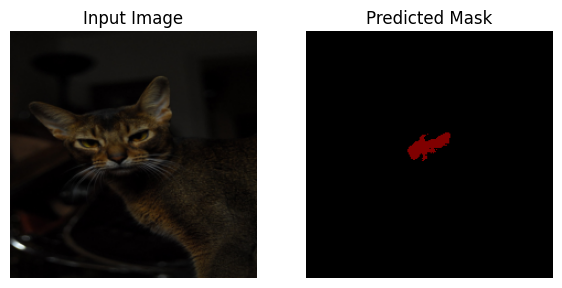

In [46]:
image_path = "../Dataset_augmented/test/color/Abyssinian_4.jpg"
image, mask = predict_mask(model, image_path, device)
visualize_prediction(image_path, mask)

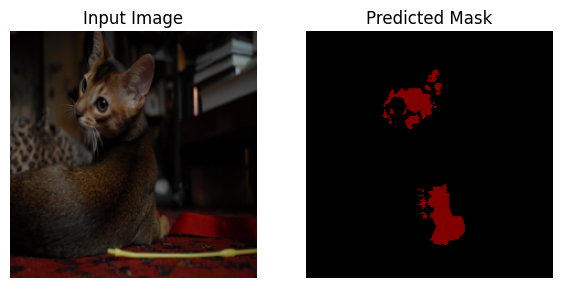

In [47]:
image_path = "../Dataset_augmented/test/color/Abyssinian_62.jpg"
image, mask = predict_mask(model, image_path, device)
visualize_prediction(image_path, mask)

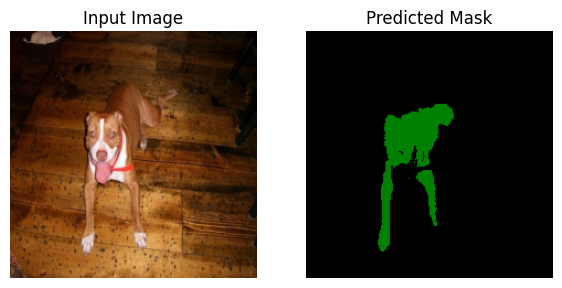

In [48]:
image_path = "../Dataset_augmented/test/color/american_pit_bull_terrier_72.jpg"
image, mask = predict_mask(model, image_path, device)
visualize_prediction(image_path, mask)

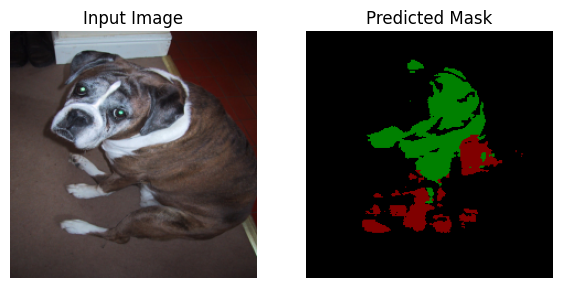

In [49]:
image_path = "../Dataset_augmented/test/color/boxer_25.jpg"
image, mask = predict_mask(model, image_path, device)
visualize_prediction(image_path, mask)